In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from scipy.integrate import solve_ivp
import sys

sys.path.append('./src/')

from initial_conditions import lamb_dipole
from poisson import poisson
from vort_rhs import vort_rhs

%matplotlib widget

/Users/benjaminghertner/Documents/portfolio_codes/VorticityDynamics/./src/initial_conditions.py:17: RuntimeWarning: invalid value encountered in divide
  sin_theta = yy/r
/var/folders/gn/cfbkg9gx4p35qfks288gj5wr0000gn/T/ipykernel_1628/4049341256.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  om0_perpnt[:-1, :-1] = om0
/var/folders/gn/cfbkg9gx4p35qfks288gj5wr0000gn/T/ipykernel_1628/4049341256.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  om0_perpnt[-1,:-1] = om0[0,:]
/var/folders/gn/cfbkg9gx4p35qfks288gj5wr0000gn/T/ipykernel_1628/4049341256.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  om0_perpnt[:-1,-1] = om0[:,0]
/var/folders/gn/cfbkg9gx4p35qfks288gj5wr0000gn/T/ipykernel_1628/4049341256.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  om0_perpnt[-1,-1]  = om0[0,0]
/Users/benjaminghertner/Documents/portfolio_codes/VorticityDynamics/./src/poi

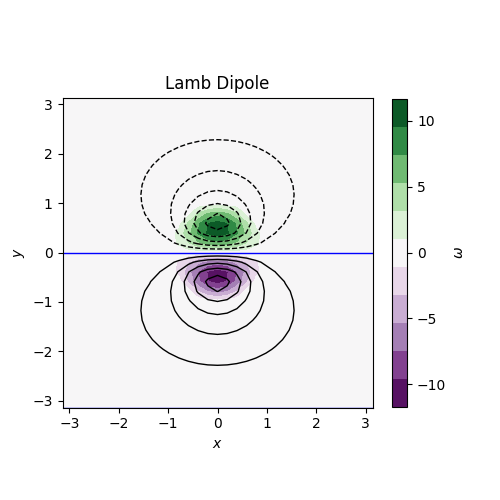

In [2]:
#Lamb Dipole Initial Conditions
N = 32
L = 2*np.pi
Uinf = 0.
om0 = lamb_dipole(Lx=L, Ly=L, Nx=N, Ny=N)

#Include periodic points for plotting
om0_perpnt = np.empty((om0.shape[0]+1,om0.shape[1]+1))
om0_perpnt[:-1, :-1] = om0
om0_perpnt[-1,:-1] = om0[0,:]
om0_perpnt[:-1,-1] = om0[:,0]
om0_perpnt[-1,-1]  = om0[0,0]

#Grid with periodic points
x = np.linspace(-L/2, L/2, N+1, endpoint=True)
y = np.linspace(-L/2, L/2, N+1, endpoint=True)
xx, yy = np.meshgrid(x, y)

ommax = np.max(np.abs(om0))*(1.1)

psi = poisson(om0, Lx=L, Ly=L, Nx=N, Ny=N, Uinf=Uinf).real
psi_perpnt = np.empty((psi.shape[0]+1,psi.shape[1]+1))
psi_perpnt[:-1, :-1] = psi
psi_perpnt[-1,:-1] = psi[0,:] - y[0]*Uinf + y[-1]*Uinf
psi_perpnt[:-1,-1] = psi[:,0]
psi_perpnt[-1,-1] =  psi[0,0] - y[0]*Uinf + y[-1]*Uinf

psimax = np.max(np.abs(psi))*(1.1)

fig, ax = plt.subplots()
fig.set_size_inches(5,5)
fig.set_dpi(500)

contf = ax.contourf(xx, yy, om0_perpnt, levels=np.linspace(-ommax, ommax, num=12), cmap='PRGn')
ax.contour(xx, yy, psi_perpnt, levels=np.linspace(0,psimax, num=7)[1:], colors='k', linewidths=1)
ax.contour(xx, yy, psi_perpnt, levels=[0], colors='b', linewidths=1)
ax.contour(xx, yy, psi_perpnt, levels=np.linspace(-psimax, 0, num=7)[:-1], colors='k', linewidths=1)
ax.set_aspect(1.0)
ax.set_xlim(-L/2,L/2)
ax.set_ylim(-L/2,L/2)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_title(r'Lamb Dipole')
fig.colorbar(contf, label=r'$\omega$', shrink=0.8, ticks=(-10, -5, 0, 5, 10))

plt.show()

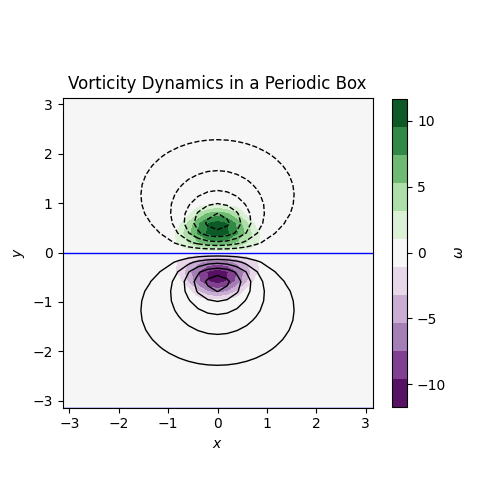

In [3]:
dt = 0.05

#Set up plot for animation

fig, ax = plt.subplots()
fig.set_size_inches(5,5)
fig.set_dpi(500)

contf = ax.contourf(xx, yy, om0_perpnt, levels=np.linspace(-ommax, ommax, num=12), cmap='PRGn')
contp = ax.contour(xx, yy, psi_perpnt, levels=np.linspace(0,psimax, num=7)[1:], colors='k', linewidths=1)
cont0 = ax.contour(xx, yy, psi_perpnt, levels=[0], colors='b', linewidths=1)
contn = ax.contour(xx, yy, psi_perpnt, levels=np.linspace(-psimax, 0, num=7)[:-1], colors='k', linewidths=1)
ax.set_aspect(1.0)
ax.set(xlim=(-L/2,L/2), 
       ylim=(-L/2,L/2), 
       xlabel=r'$x$', 
       ylabel=r'$y$', 
       title=r'Vorticity Dynamics in a Periodic Box')
fig.colorbar(contf, label=r'$\omega$', shrink=0.8, ticks=(-10, -5, 0, 5, 10))

plots = {'contf':contf, 
         'contp':contp,
         'cont0':cont0,
         'contn':contn}

#initial condition
global om
om = om0

def animate(i):
    global om

    if i == 0: om = om0
    
    #clear old plot elements
    plots['contf'].remove()
    plots['contp'].remove()
    plots['cont0'].remove()
    plots['contn'].remove()


    #Preform time step
    sol = solve_ivp(lambda t, y: vort_rhs(y, L, L, N, N, Uinf),
                (0.0, dt),
                om.flatten(),
                method='RK23',
                atol=1e-10, rtol=1e-10)

    om = np.reshape(sol.y[:,-1], (N,N))

    #Include periodic points for plotting
    om_perpnt = np.empty((om.shape[0]+1,om.shape[1]+1))
    om_perpnt[:-1, :-1] = om
    om_perpnt[-1,:-1] = om[0,:]
    om_perpnt[:-1,-1] = om[:,0]
    om_perpnt[-1,-1]  = om[0,0]

    psi = poisson(om, Lx=L, Ly=L, Nx=N, Ny=N, Uinf=Uinf).real
    psi_perpnt = np.empty((psi.shape[0]+1,psi.shape[1]+1))
    psi_perpnt[:-1, :-1] = psi
    psi_perpnt[-1,:-1] = psi[0,:] - y[0]*Uinf + y[-1]*Uinf
    psi_perpnt[:-1,-1] = psi[:,0]
    psi_perpnt[-1,-1] =  psi[0,0] - y[0]*Uinf + y[-1]*Uinf

    #Redraw plot
    plots['contf'] = ax.contourf(xx, yy, om_perpnt, levels=np.linspace(-ommax, ommax, num=12), cmap='PRGn')
    plots['contp'] = ax.contour(xx, yy, psi_perpnt, levels=np.linspace(0,psimax, num=7)[1:], colors='k', linewidths=1)
    plots['cont0'] = ax.contour(xx, yy, psi_perpnt, levels=[0], colors='b', linewidths=1)
    plots['contn'] = ax.contour(xx, yy, psi_perpnt, levels=np.linspace(-psimax, 0, num=7)[:-1], colors='k', linewidths=1)

    return plots

an = ani.FuncAnimation(fig=fig, func=animate, blit=False, interval=50, 
                       frames=100, repeat=True, repeat_delay=5e3) 

plt.show()